# PyTorch Implementations of Coffee Roasting Network

This is a Simple Neural Network from **Advanced Learning Algorithms** at Coursera - the second course from Machine Learning specialization with Andrew Ng.

This Notebook is copied from the original course. All changes in the commentaries, made by me, are in *italics*. I also tried to comment my code for it to be clear and understandable.




# Optional Lab - Simple Neural Network
In this lab we will build a small neural network using Tensorflow.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import tensorflow as tf
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit


## DataSet

In [2]:
X, Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink.

In [3]:
# Copy-pasted from the course
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
               edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

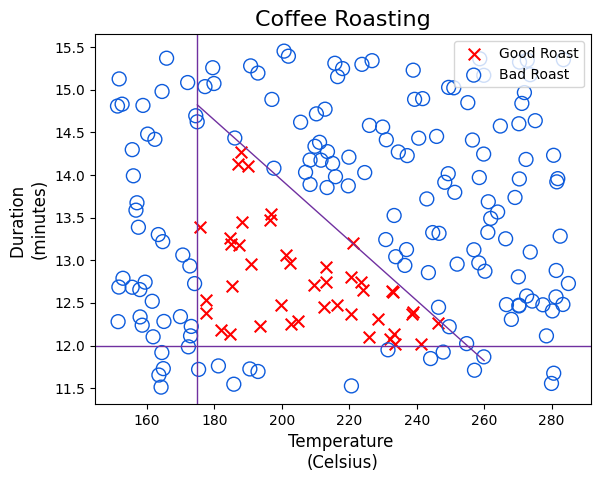

In [4]:
plt_roast(X, Y)

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range.

**NB**: *since I am not using tensorflow, I perform z-score normalization manually, by computing mean and standard deviation in numpy. The results are identical to the course's ones.*

In [5]:

print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
Xn = (X - mean) / std

print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.
*Tiling means simple duplication*

In [6]:
Xt = np.tile(Xn,(1000,1))
Yt = np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


## Pytorch Model

### Model
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations

In [7]:
class CoffeeRoaster(nn.Module):
  def __init__(self):
    super(CoffeeRoaster, self).__init__()

    self.loss = []  # track loss in the model

    self.linear1 = nn.Linear(2, 3)  # 2 input features, 3 features in the layer
    self.sigmoid1 = nn.Sigmoid()
    self.linear2 = nn.Linear(3, 1)  # 3 features from the hidden layer, 1 output
    self.sigmoid2 = nn.Sigmoid()

    if torch.cuda.is_available():   # Move the model to the GPU (if we have one)
      self.cuda()


  def forward(self, x):
    x = self.linear1(x)
    x = self.sigmoid1(x)
    x = self.linear2(x)
    x = self.sigmoid2(x)
    return x

Print the summary of the model:

In [8]:
coffee_roaster = CoffeeRoaster()
print(f'{coffee_roaster}')

CoffeeRoaster(
  (linear1): Linear(in_features=2, out_features=3, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid2): Sigmoid()
)


*Let's print parameters of the model.* **NB**: *In pytorch, the vectors are transposed in comparison to tensorflow. In tf, the first layer had params (2, 3), while in pytorch it's (3, 2). Likewise with the second layer: (3, 1) in tensorflow and (1, 3) in pytorch.*

In [9]:
for name, param in coffee_roaster.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}, Values: {param.data}')

Layer: linear1.weight, Size: torch.Size([3, 2]), Values: tensor([[ 0.1395, -0.2527],
        [ 0.1804, -0.1073],
        [-0.4220,  0.6540]], device='cuda:0')
Layer: linear1.bias, Size: torch.Size([3]), Values: tensor([ 0.1136, -0.2041, -0.6832], device='cuda:0')
Layer: linear2.weight, Size: torch.Size([1, 3]), Values: tensor([[ 0.5279, -0.1341, -0.1224]], device='cuda:0')
Layer: linear2.bias, Size: torch.Size([1]), Values: tensor([0.1227], device='cuda:0')


Let's examine the weights and biases *Pytorch* has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [10]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(coffee_roaster.parameters(), lr=0.01)  # lr is learning rate

In [11]:
def batch_iterator(X, y, batch_size=32):
    """Helper function for iterating over batches of the data"""

    for i in range(0, len(X), batch_size):
      # Convert the NumPy array to a PyTorch tensor to work in PyTorch
      X_ = torch.tensor(X[i:batch_size+i], dtype=torch.float32)
      y_ = torch.tensor(y[i:batch_size+i], dtype=torch.float32)
      if torch.cuda.is_available():
        yield X_.cuda(), y_.cuda()
      else:
         yield X_, y_


*Unfortunately, in pytorch it's impossible to call `model.fit` and train your model. Instead, one should write training function themselves. Here, I am using code from the tutorial of pytorch from [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) with some mild modifications.*

In [12]:
# function for training model per one epoch

def train_one_epoch(batch_size=32):
    batch_loss = []

    # Iterate simultaneously over inputs and labels
    for i, batch in enumerate(batch_iterator(Xt, Yt, batch_size=batch_size)):

        # Get inputs and labels
        inputs, labels = batch

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = coffee_roaster(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Track the loss
        batch_loss.append(loss.item())

    # track all the loss in the model
    coffee_roaster.loss.extend(batch_loss)
    return sum(batch_loss) / batch_size

In [13]:
# train model within epochs

from tqdm import tqdm  # for printing ETA

EPOCHS = 10

batch_size = 32

for epoch in (tqdm_bar := tqdm(range(EPOCHS))):
  coffee_roaster.train(True)
  avg_loss_per_epoch = train_one_epoch(batch_size)
  tqdm_bar.set_description(f"Epoch {epoch+1}/{EPOCHS}; Loss {avg_loss_per_epoch:.4f}")
  print()


Epoch 1/10; Loss 35.5883:  10%|█         | 1/10 [00:08<01:16,  8.51s/it]

Epoch 2/10; Loss 15.8063:  20%|██        | 2/10 [00:16<01:06,  8.27s/it]

Epoch 3/10; Loss 4.4114:  30%|███       | 3/10 [00:24<00:56,  8.13s/it]

Epoch 4/10; Loss 2.7173:  40%|████      | 4/10 [00:32<00:48,  8.15s/it]

Epoch 5/10; Loss 1.9047:  50%|█████     | 5/10 [00:40<00:40,  8.09s/it]

Epoch 6/10; Loss 1.3771:  60%|██████    | 6/10 [00:48<00:32,  8.06s/it]

Epoch 7/10; Loss 0.9983:  70%|███████   | 7/10 [00:56<00:24,  8.03s/it]

Epoch 8/10; Loss 0.7211:  80%|████████  | 8/10 [01:04<00:16,  8.01s/it]

Epoch 9/10; Loss 0.5201:  90%|█████████ | 9/10 [01:12<00:08,  8.01s/it]

Epoch 10/10; Loss 0.3763: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]

*Here, the final loss is different from the one from tensorflow (0.0020 there) but it steadily descreases over epochs*

#### Epochs and batches
In the *`EPOCHS` variable* above, the number was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10; Loss 38.1654:  10%|█         | 1/10 [00:08<01:14,  8.30s/it]

```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32 *(therefore, the batch size in pytorch also was set to 32)*. There are 200000 examples in our expanded data set or 6250 batches.

*Here, I am also printing the current loss of each epoch.*

**NB**: *here, seed is not set, so with every rerun of this notebook, loss might be a bit different because of randomness.*

#### Updated Weights
After fitting, the weights have been updated:

In [14]:
for name, param in coffee_roaster.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}, Values: {param.data}')

Layer: linear1.weight, Size: torch.Size([3, 2]), Values: tensor([[13.7392,  0.2961],
        [-0.0582, -8.7129],
        [15.6724, 13.0668]], device='cuda:0')
Layer: linear1.bias, Size: torch.Size([3]), Values: tensor([ 14.3691, -10.8862,   1.9581], device='cuda:0')
Layer: linear2.weight, Size: torch.Size([1, 3]), Values: tensor([[ 39.9793, -48.1474, -43.9455]], device='cuda:0')
Layer: linear2.bias, Size: torch.Size([1]), Values: tensor([-12.5803], device='cuda:0')


You can see that the values are different from what you printed before *training it*. With these, the model should be able to discern what is a good or bad coffee roast.

For the purpose of the next discussion, instead of using the weights you got right away, you will first set some weights we saved from a previous training run. This is so that this notebook remains robust to changes in Tensorflow over time. Different training runs can produce somewhat different results and the following discussion applies when the model has the weights you will load below.

Feel free to re-run the notebook later with the cell below commented out to see if there is any difference. If you got a low loss after the training above (e.g. 0.002), then you will most likely get the same results.

In [15]:
# After finishing the lab later, you can re-run all
# cells except this one to see if your trained model
# gets the same results.

# Set weights from a previous run.
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]])
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])

# Replace the weights from your trained model with the values above.
coffee_roaster.linear1.weight.data = torch.tensor(W1.T, dtype=torch.float32)  # transpose W1, since PyTorch and Tensorflow handle data differently
coffee_roaster.linear1.bias.data = torch.tensor(b1.T, dtype=torch.float32)
coffee_roaster.linear2.weight.data = torch.tensor(W2.T, dtype=torch.float32)
coffee_roaster.linear2.bias.data = torch.tensor(b2, dtype=torch.float32)

In [16]:
for name, param in coffee_roaster.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}, Values: {param.data}')

Layer: linear1.weight, Size: torch.Size([3, 2]), Values: tensor([[-8.9400, -0.1700],
        [ 0.2900, -7.3400],
        [12.8900, 10.7900]])
Layer: linear1.bias, Size: torch.Size([3]), Values: tensor([-9.8700, -9.2800,  1.0100])
Layer: linear2.weight, Size: torch.Size([1, 3]), Values: tensor([[-31.3800, -27.8600, -32.7900]])
Layer: linear2.bias, Size: torch.Size([1]), Values: tensor([15.5400])


### Predictions
Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [17]:
def norm_l(x, mean=mean, std=std):
    return (x - mean) / std

In [18]:
X_test = np.array([
    [200,13.9],  # positive example
    [200, 17]])   # negative example
X_testn = torch.tensor(norm_l(X_test), dtype=torch.float32)
print(X_testn)


tensor([[-0.4671,  0.4159],
        [-0.4671,  3.1631]])


In [19]:
def predict(x):
  coffee_roaster.eval()  # set the model to evaluation mode
  with torch.no_grad():  # Disable gradient calculation for inference
      predictions = coffee_roaster(X_testn)
  return predictions.numpy()

predictions = predict(X_testn)
print(f"predictions = \n{predictions}")

predictions = 
[[9.63e-01]
 [3.03e-08]]


*(Note that these results are exactly the same as the results from the original Tensorflow code)*

To convert the probabilities to a decision, we apply a threshold.

In [20]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.

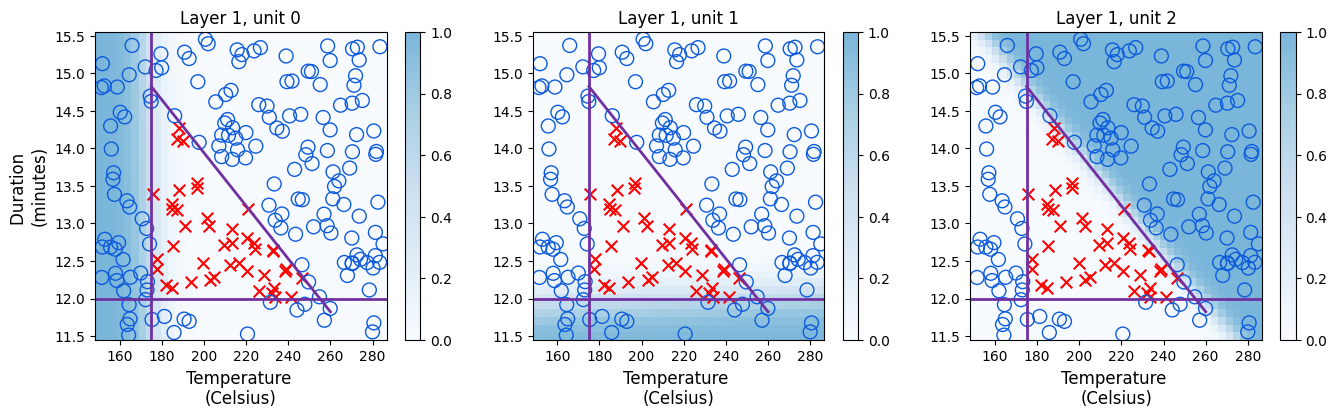

In [21]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

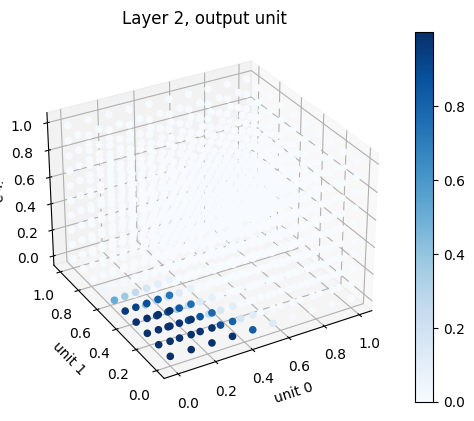

In [22]:
plt_output_unit(W2,b2)

The final graph shows the whole network in action.  
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  
The following takes a moment to run

*(Didn't manage to redo in pytorch!)*

In [ ]:
netf = lambda x : predict(norm_l(x))
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in Tensorflow.
The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.